# Challenge ML

**Bienvenue dans le challenge ML !** Il s'agit d'évaluer les compétences acquises pour développer un modèle de Machine Learning.

Vous allez développer un classifieur automatique de Spam grâce à une collection existante de SMS labellisés (Spam / Ham). Ce dataset provient de [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).  
Pour ce challenge, voici les étapes sur lesquelles vous serez particulièrement évalué :
- Preprocessing
- Automatisation du process avec un pipeline
- Entrainement et validation croisée des modèles
- Recherche des hyper-paramètres
- Comparaison de différents modèles de classification
- Sélection d'une métrique d'erreur convenablement choisie vis-à-vis du contexte
- Sélection d'un modèle de classification et justification du choix  

Et en bonus :
- Compréhension et analyses des erreurs du modèle
- Compréhension et analyses des caractéristiques (features) d'intérêt
  
**Consignes :**
- Faites une copie de ce notebook et modifiez-le librement.
- Structuer votre notebook afin d'en faire un véritable rapport :
  - Titres, zones de texte et zones de code.
  - Il est important d'apporter des explications et des justifications pour les choix réalisés.
- En fin de challenge, partagez votre travail sur Simplonline (veuillez vous assurer que les accès à votre document sont autorisés à des tiers).



#1.Chargement des librairies

In [1]:
# Data
import pandas as pd

In [2]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

[nltk_data] Downloading package stopwords to /home/dakoro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#2.Chargement de la collection de SMS

In [3]:
url = "https://raw.githubusercontent.com/remijul/dataset/master/SMSSpamCollection"
df = pd.read_csv(url, sep="\t", header=0, names=['label', 'message'])
df.head()

,label,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [4]:
df.shape

(5571, 2)

In [5]:
df['length'] = df['message'].apply(lambda x: len(x.split()))

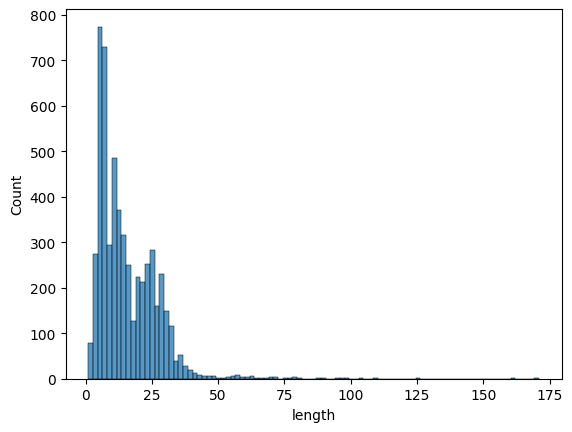

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['length'])
plt.show()

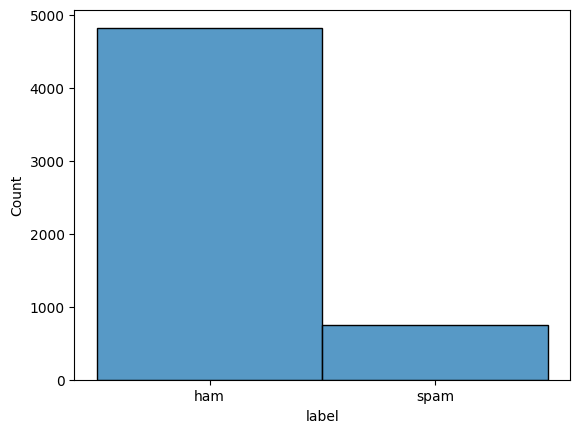

In [7]:
sns.histplot(df['label'])
plt.show()

remarque : il y plus de ham que spam

In [8]:
y = df['label']
y.value_counts()

label
ham     4824
spam     747
Name: count, dtype: int64

## Remarque sur la target
- la classe est déséquilibrer

In [9]:
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/dakoro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
ham_words = ''
spam_words = ''

In [11]:
for val in df[df['label'] == 'spam'].message:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in df[df['label'] == 'ham'].message:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [12]:
from wordcloud import WordCloud
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

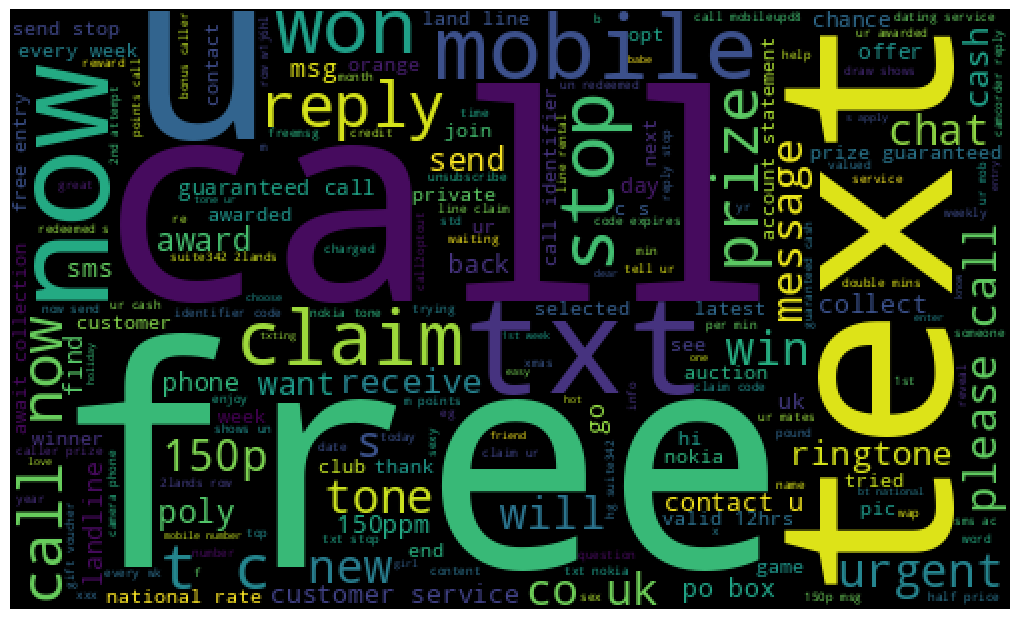

In [13]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

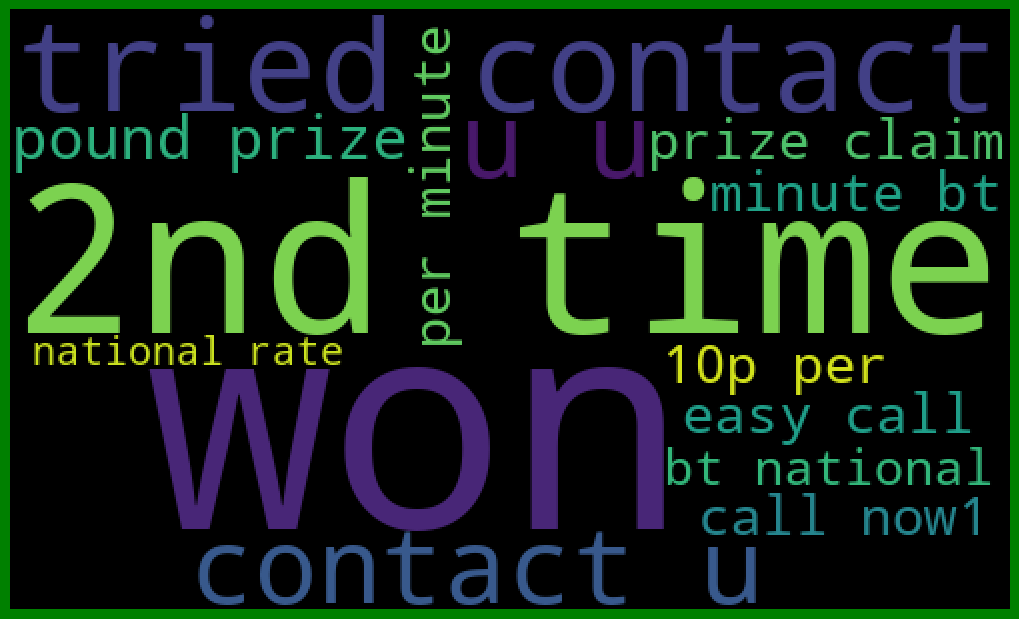

In [14]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Conclusion sur l'analyse
- le lexique pour la classe 'ham' est plus diversifié que celui de spam
- On constate une fréquence importante des mots 'won' et 'time' dans les spams 

In [15]:
df['message'] = df['message'].apply(text_process)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn.naive_bayes import MultinomialNB

label_enc = LabelEncoder()

X = df['message']

mnb = MultinomialNB(alpha=0.2)
svc = SVC(kernel='sigmoid', gamma=1.0)
voting = VotingClassifier(estimators=[('svc', svc), ('mnb', mnb)])
stack = StackingClassifier(estimators=[('svc', svc), ('mnb', mnb)])

y = label_enc.fit_transform(y)

pipe_mnb = Pipeline(steps=[
    ('tfi', TfidfVectorizer()),
    ('model', mnb)
])

pipe_svc = Pipeline(steps=[
    ('tfi', TfidfVectorizer()),
    ('model', svc)
])

pipe_voting = Pipeline(steps=[
    ('tfi', TfidfVectorizer()),
    ('model', voting)
])

pipe_stack = Pipeline(steps=[
    ('tfi', TfidfVectorizer()),
    ('model', stack)
])

pipe_list = [pipe_mnb, pipe_svc, pipe_voting, pipe_stack]



In [17]:
params_mnb = {'model__alpha': [0.1, 0.2, 0.3, 0.4]}
params_svc = {'model__C': [0.8, 1.0, 1.2]}
params_voting = {'model__voting': ['hard', 'soft']}
params_stack = {'model__stack_method': ['predict_proba', 'decision_function', 'predict']}

params_list = [params_mnb, params_svc, params_voting, params_stack]

In [18]:
from sklearn.model_selection import GridSearchCV


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Choix d'une métrique d'erreur pour le grid search
- Le plus intéressant est de d'obtenir un classifier qui detect le maximum de spam possible
  - Donc le recall est la métrique retenue pour l'évaluation du meilleur modèle
  - Le classifier retenue sera celui qui permettra de detecter le plus de spam

In [20]:
estimators = []
for pipe, params in zip(pipe_list, params_list):
    model = GridSearchCV(pipe, params, cv=5, n_jobs=-1, verbose=2, scoring='recall')
    model_fit = model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    estimators.append(best_estimator)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV] END ...................................model__alpha=0.1; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.5s
[CV] END ...................................model__alpha=0.2; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.4s
[CV] END ...................................model__alpha=0.2; total time=   0.3s
[CV] END ...................................model__alpha=0.2; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.4s
[CV] END ...................................model__alpha=0.2; total time=   0.3s
[CV] END ...................................model__alpha=0.3; total time=   0.3s
[CV] END ...................................model__alpha=0.3; total time=   0.4s
[CV] END ...................................model__alpha=0.3; total time=   0.3s
[CV] END ...................

/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/

[CV] END .................................model__voting=hard; total time=   2.6s
[CV] END .................................model__voting=hard; total time=   2.6s
[CV] END .................................model__voting=soft; total time=   2.5s
[CV] END .................................model__voting=soft; total time=   2.6s


/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/

[CV] END .................................model__voting=hard; total time=   2.8s
[CV] END .................................model__voting=hard; total time=   2.9s


/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/dakoro/Téléchargements/ML_challenge_David/ML_challenge/lib/

[CV] END .................................model__voting=soft; total time=   1.4s
[CV] END .................................model__voting=soft; total time=   1.4s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..................model__stack_method=predict_proba; total time=   1.8s
[CV] END ..............model__stack_method=decision_function; total time=   2.0s
[CV] END ..............model__stack_method=decision_function; total time=   2.0s
[CV] END ..................model__stack_method=predict_proba; total time=   2.1s
[CV] END ..............model__stack_method=decision_function; total time=   2.1s
[CV] END ..................model__stack_method=predict_proba; total time=   2.2s
[CV] END ..................model__stack_method=predict_proba; total time=   2.2s
[CV] END ..................model__stack_method=predict_proba; total time=   2.3s
[CV] END ..............model__stack_method=decision_function; total time=   1.6s
[CV] END ..............model__stack_method=decisi

In [21]:
from sklearn.metrics import classification_report
clf_labels = ['MNB', 'SVC', 'Voting', 'Stack']
for estimator, name in zip(estimators, clf_labels):
    y_pred = estimator.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

MNB
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       955
        spam       0.98      0.89      0.93       160

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

SVC
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       955
        spam       0.97      0.90      0.93       160

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Voting
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       955
        spam       1.00      0.86      0.92       160

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Stac

Normalized confusion matrix MNB
[[0.99685864 0.00314136]
 [0.10625    0.89375   ]]
Normalized confusion matrix SVC
[[0.9947644 0.0052356]
 [0.1       0.9      ]]
Normalized confusion matrix Voting
[[1.      0.     ]
 [0.14375 0.85625]]
Normalized confusion matrix Stack
[[0.99790576 0.00209424]
 [0.1125     0.8875    ]]


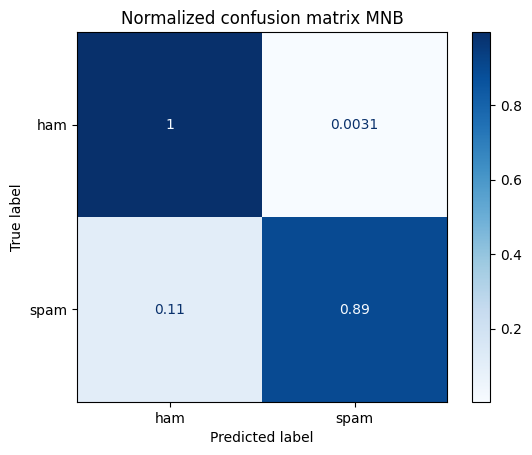

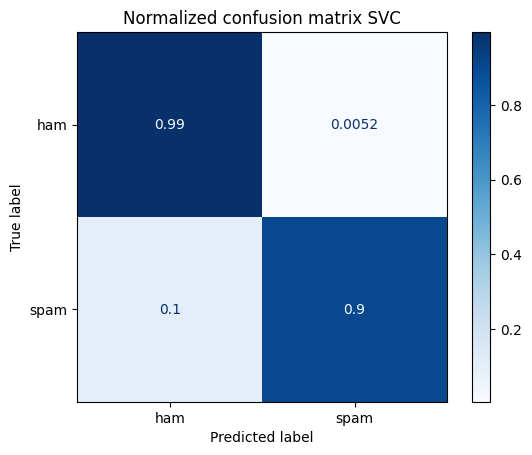

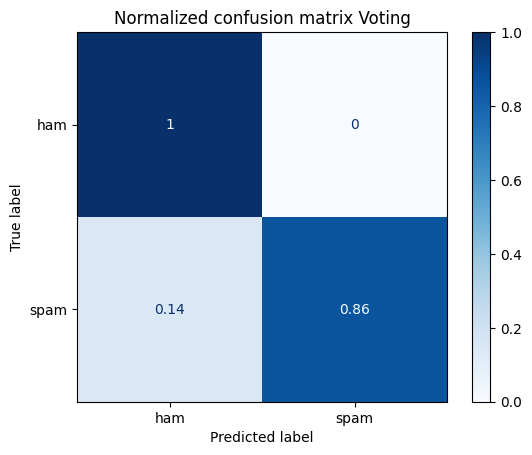

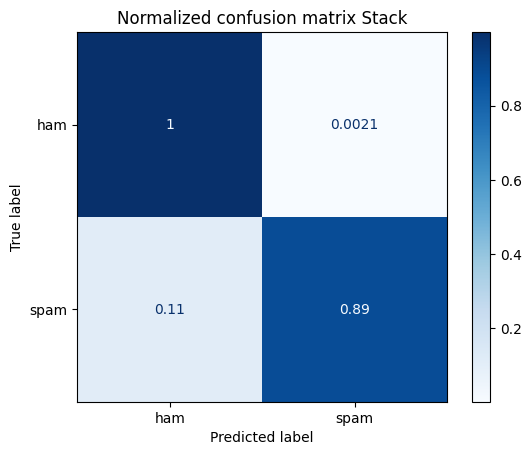

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
titles_options = [
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    for estimator, name in zip(estimators, clf_labels):
        disp = ConfusionMatrixDisplay.from_estimator(
            estimator,
            X_test,
            y_test,
            display_labels=['ham', 'spam'],
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title + ' '+ name)

        print(title,  name)
        print(disp.confusion_matrix)

    plt.show()

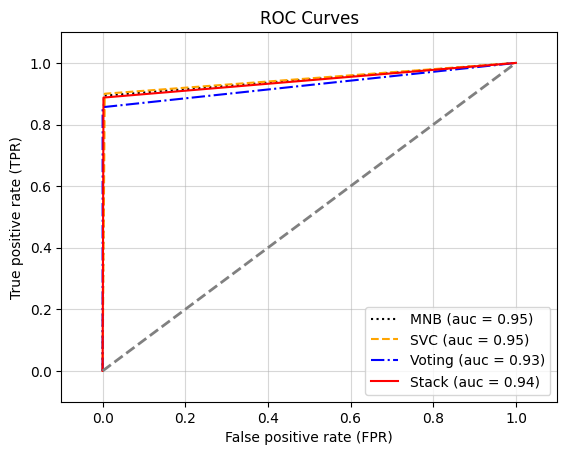

In [23]:
from sklearn.metrics import roc_curve, auc

all_clf = estimators

colors = ['black', 'orange', 'blue', 'red']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
# assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curves')
plt.show()

## Analyse de la selection des modèles
- L'ensemble des modèle dispose de bonnes performances sur l'ensemble des métriques (> 0.91)
- Le recall sur les spam est la métrique la plus difficile à optimiser sur ce classifier
- Le modèle qui dispose du meilleur recall sur les spam est le SVC, c'est donc le modèle recommandé
- C'est egalement le modèle avec la meilleur auc